# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load the FL endothelial cells

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/liver/data/fetal_liver_alladata_Copy1.h5ad")

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell                            1079
DC1                                336
DC2                               3954
DC precursor                       330
Early Erythroid                  11985
Early lymphoid_T lymphocyte        767
Endothelial cell                  3348
Fibroblast                        1713
HSC_MPP                           3439
Hepatocyte                        2479
ILC precursor                     1726
Kupffer Cell                     24841
Late Erythroid                    3180
MEMP                              1342
Mast cell                         1308
Megakaryocyte                     3983
Mid Erythroid                    27000
Mono-Mac                          6590
Monocyte                          2586
Monocyte precursor                 350
NK                                6706
Neutrophil-myeloid progenitor      658
Pre pro B cell                     234
VCAM1+ EI macrophage               161
pDC precursor                      253
pre-B cell   

In [6]:
adata = adata[adata.obs['cell.labels'].isin(['Endothelial cell'])].copy()

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Endothelial cell    3348
dtype: int64

# Pre-process the FL endo dataset

In [8]:
# normalise count data 
sc.pp.normalize_total(adata)

In [9]:
# log the count data 
sc.pp.log1p(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 3348 × 27080 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'fetal.ids', 'sort.ids', 'tissue', 'lanes', 'stages', 'sample.type', 'gender', 'AnnatomicalPart', 'doublets', 'cell.labels', 'combined.labels', 'batch', 'sample', 'n_counts'
    obsm: 'X_fdg', 'X_tsne', 'X_umap'

In [11]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [12]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [13]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [14]:
# run pca
sc.tl.pca(adata, n_comps=50)

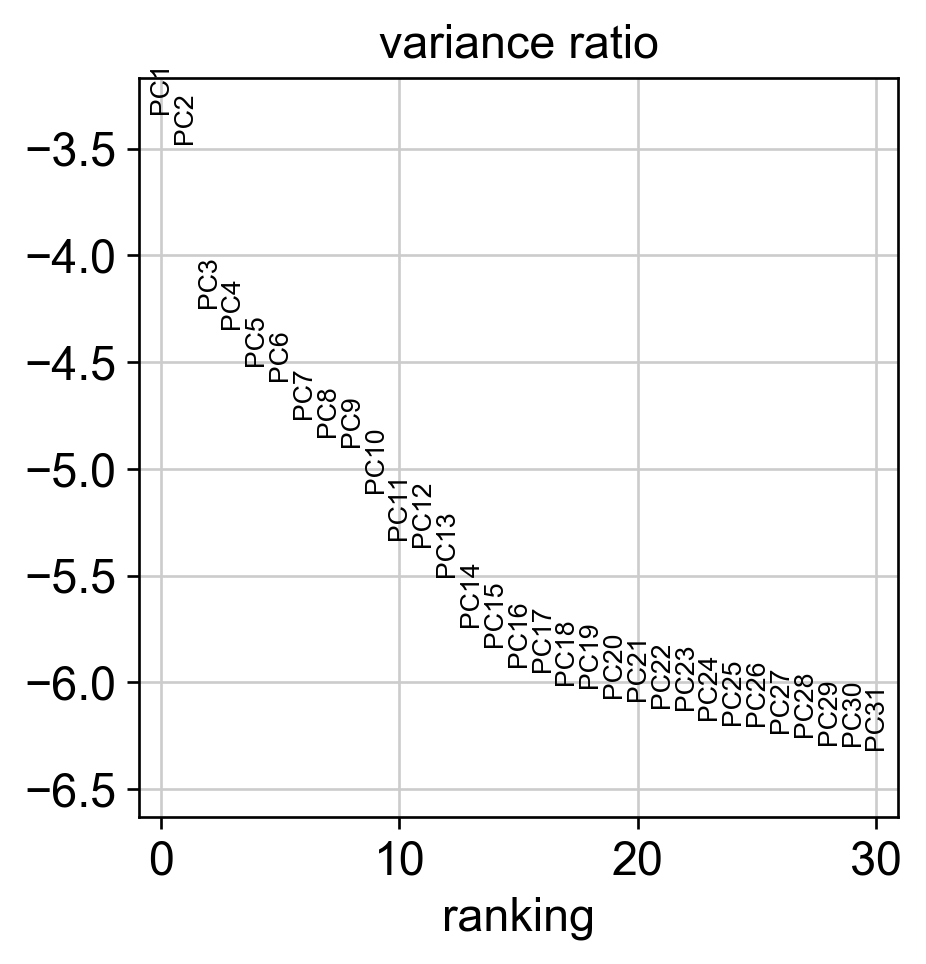

In [15]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [16]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [17]:
# run umap
sc.tl.umap(adata) 

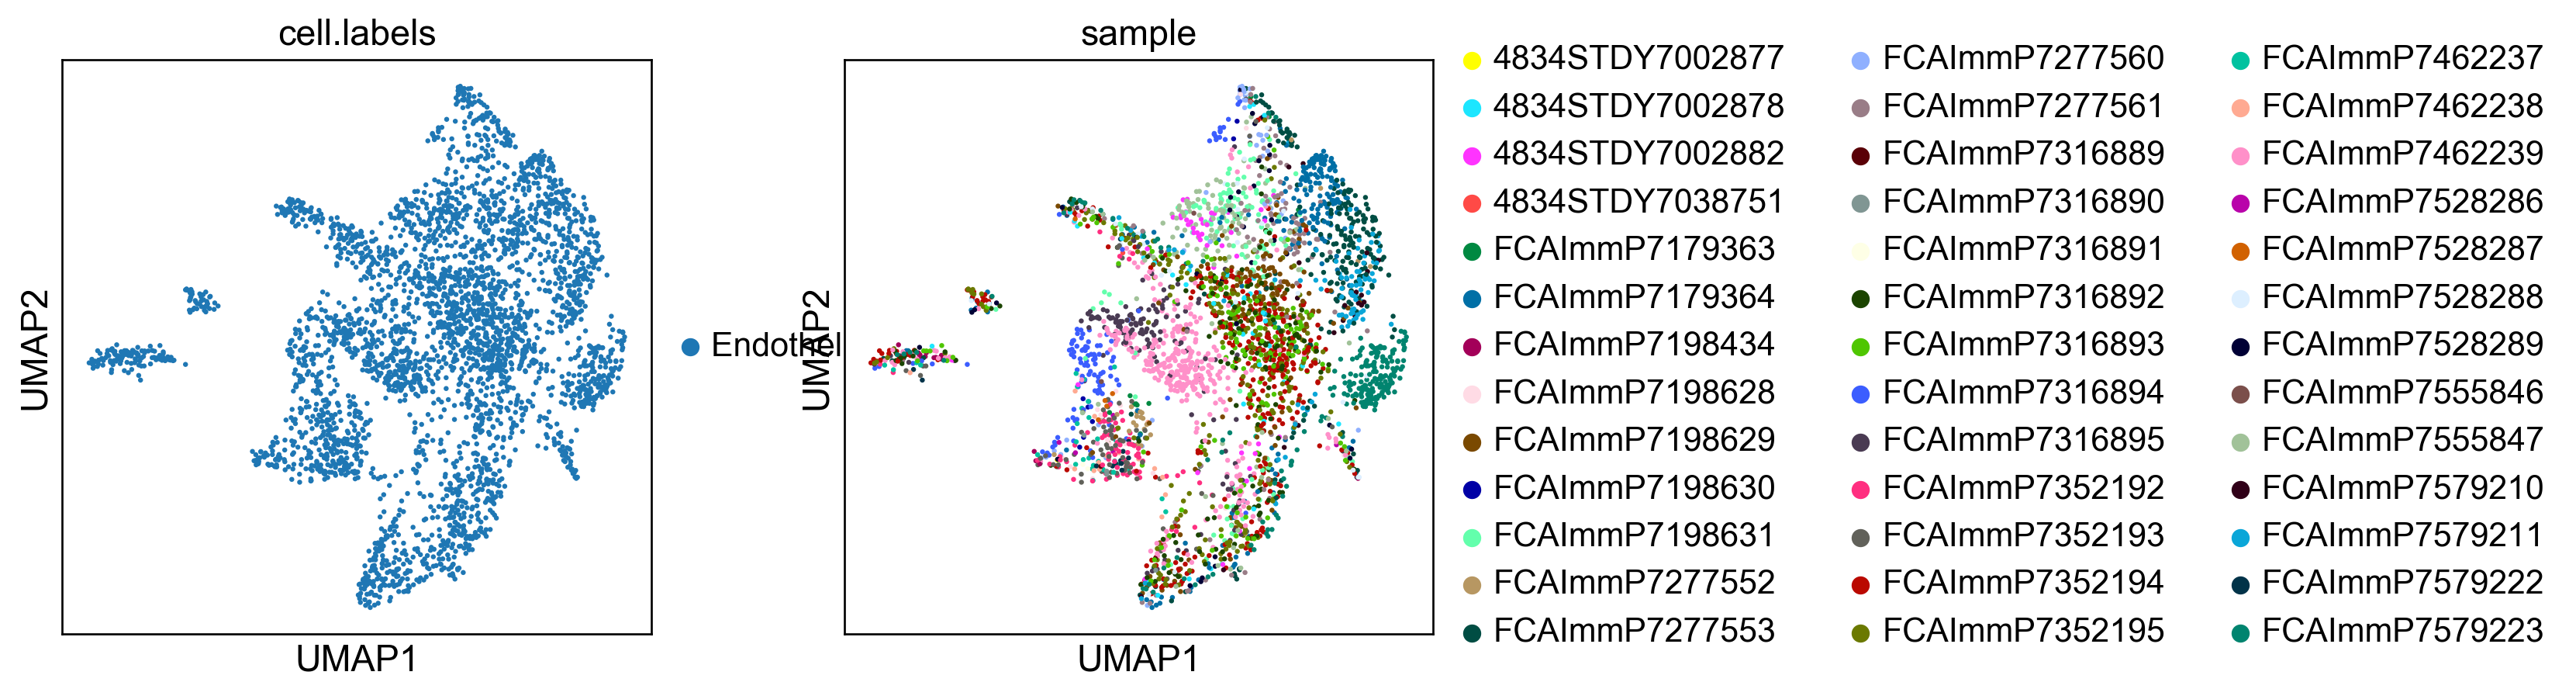

In [18]:
sc.pl.umap(adata, color=['cell.labels', 'sample'], size=15) 

# Run harmony batch correction

In [19]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['sample']

In [20]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [21]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [22]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

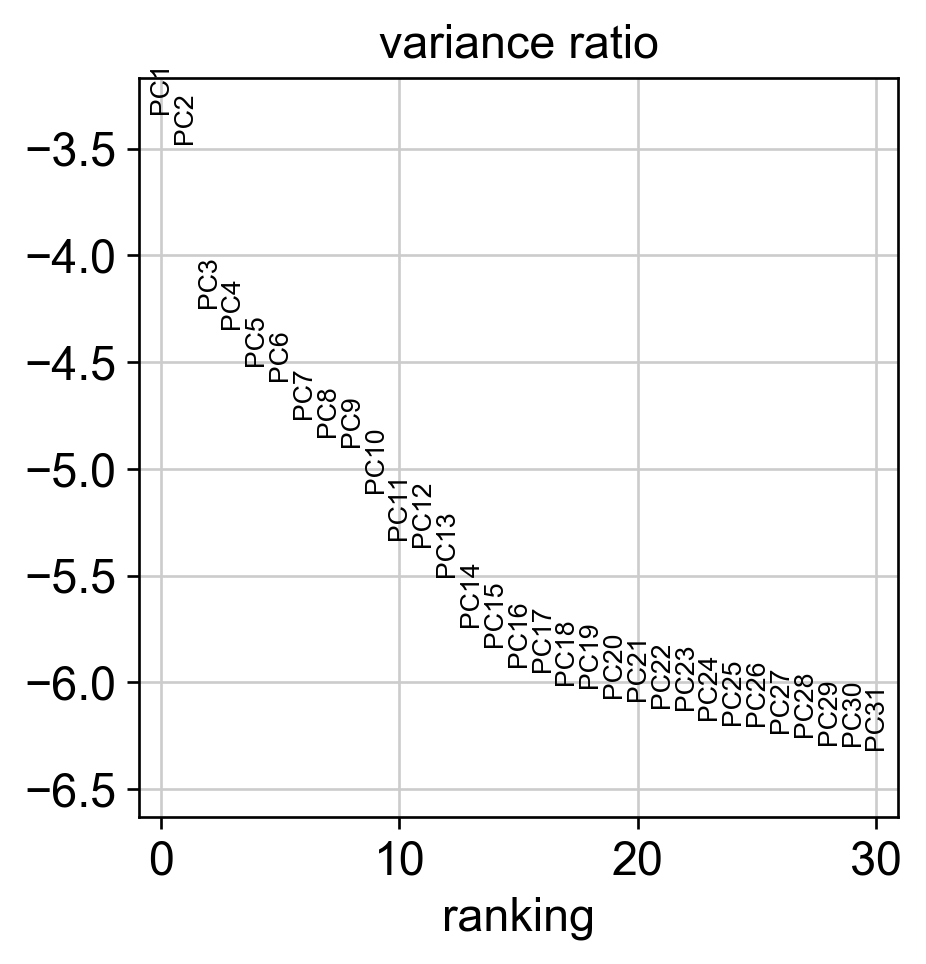

In [23]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [25]:
# run umap
sc.tl.umap(adata)

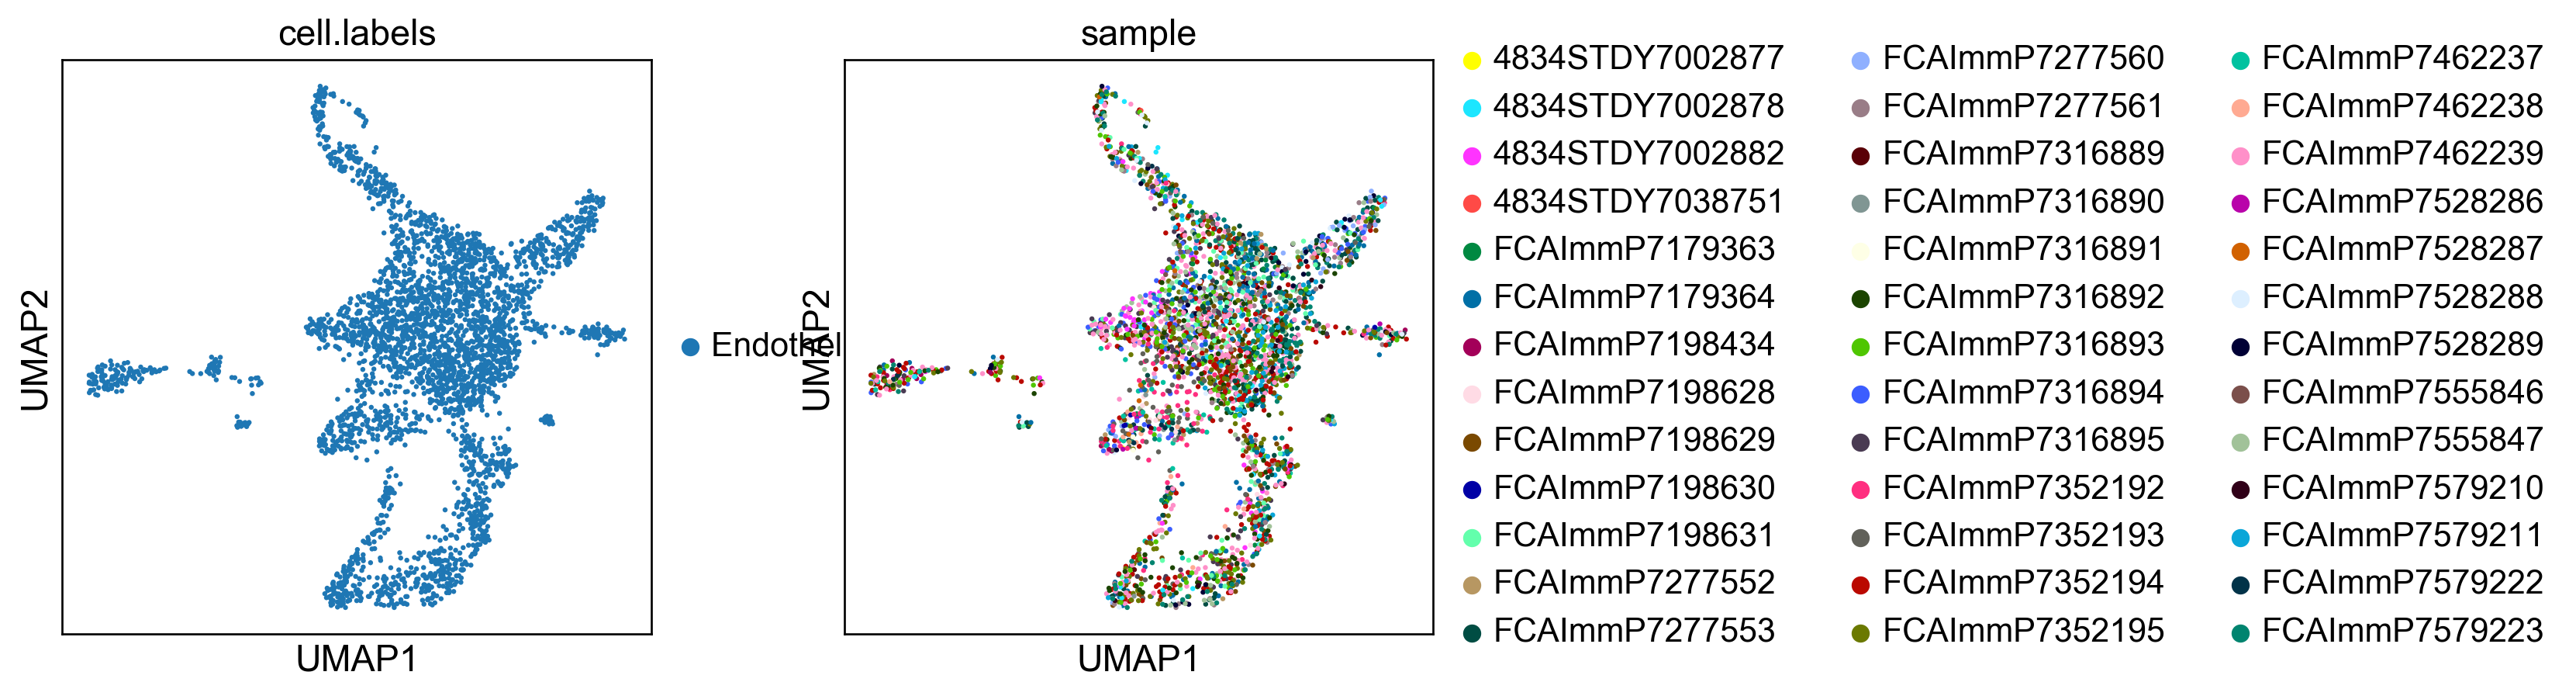

In [26]:
sc.pl.umap(adata, color=['cell.labels', 'sample'], size=15) 

# Cluster FL endo to around 10 groups

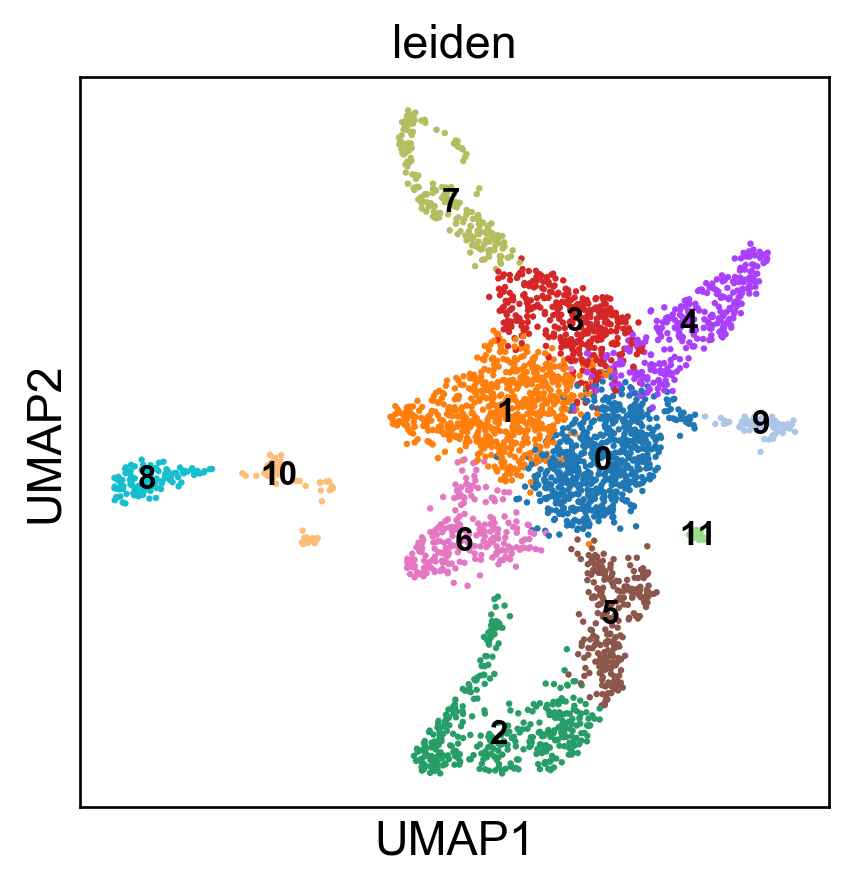

In [27]:
sc.tl.leiden(adata, resolution=0.5, random_state=26, n_iterations=-1) 
sc.pl.umap(adata, color='leiden', legend_loc="on data", size=15, legend_fontsize=10)

In [28]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', use_raw=False, log_transformed=True)

In [29]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [30]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fl_endo_degs.csv")
degs_by_cluster[:10]

,0_n,0_l,1_n,1_l,2_n,2_l,3_n,3_l,4_n,4_l,...,7_n,7_l,8_n,8_l,9_n,9_l,10_n,10_l,11_n,11_l
0,SEPP1,2.006828,JUNB,1.458872,H2AFZ,4.080687,FEZ1,2.376724,CALM2,2.655452,...,CLEC14A,4.131516,COLEC11,9.797002,MT1G,5.696774,COL3A1,7.776725,ACRBP,8.380454
1,FCN3,1.514062,ZFP36,1.509302,TUBA1B,4.230011,PLPP3,1.711167,RAMP3,3.652977,...,CD320,4.902706,DLK1,7.023632,FABP1,6.019900,LGALS1,5.131556,PF4,3.738693
2,S100A16,1.580504,SOCS3,1.323115,STMN1,3.834900,IL33,1.709978,HYAL2,2.285509,...,EDNRB,4.594384,COLEC10,10.910662,MT1E,5.650970,PTN,7.284101,DAAM1,1.448179
3,ECM1,1.593485,FGF23,1.365391,HMGB2,4.553293,CLEC1B,1.399238,NDUFA8,2.418431,...,MDK,3.329549,BGN,5.891674,APOA2,5.189436,OGN,13.406157,TUBB1,7.931517
4,GPX1,1.468390,EGR1,1.396181,MKI67,6.150425,ADD3,1.716321,WNT2,5.236124,...,VIM,3.971519,IGFBP3,6.133235,MT1H,5.766194,VIM,3.425873,PPBP,5.211299
5,CLEC4M,1.880262,SERTAD1,1.547013,HMGN2,3.905906,CD36,1.391143,LYPD2,5.766364,...,FLRT2,4.065078,DCN,8.746429,SERPINA1,5.453780,COL1A1,8.252879,UGCG,1.441900
6,CCL23,1.986445,FLT1,1.552192,TUBB,3.749496,IFITM3,1.422902,CD59,2.274963,...,TM4SF1,2.837937,CXCL12,8.360232,MT2A,4.133637,TPM2,4.754519,PIM3,1.595569
7,OIT3,1.248865,ICAM1,1.947220,UBE2C,5.310729,CRHBP,1.259738,NTS,2.328485,...,TMSB10,2.727604,SPARC,4.598765,ALB,4.828735,DCN,5.676247,NT5C3A,2.937814
8,MS4A6A,1.370697,CREM,1.626376,NUSAP1,5.556428,SNX6,1.506075,THBD,2.853623,...,CD9,6.533045,GPX3,7.864483,APOC1,4.848303,PLAC9,6.332567,UPP1,1.520835
9,GMFG,1.246764,UGCG,1.521507,TOP2A,5.931534,C8orf4,1.471148,IFITM3,1.632979,...,ADAMTS9,3.331338,PTN,8.169841,AHSG,5.233679,CALD1,2.770729,GP9,5.049118


In [31]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fl_endo_degs_filtered.csv")
degs_by_cluster_filtered[:10]

,0_n,0_l,1_n,1_l,2_n,2_l,3_n,3_l,4_n,4_l,...,7_n,7_l,8_n,8_l,9_n,9_l,10_n,10_l,11_n,11_l
0,SEPP1,2.006828,NaN,1.458872,H2AFZ,4.080687,FEZ1,2.376724,CALM2,2.655452,...,CLEC14A,4.131516,COLEC11,9.797002,MT1G,5.696774,COL3A1,7.776725,ACRBP,8.380454
1,NaN,1.514062,NaN,1.509302,TUBA1B,4.230011,PLPP3,1.711167,RAMP3,3.652977,...,CD320,4.902706,DLK1,7.023632,FABP1,6.019900,LGALS1,5.131556,PF4,3.738693
2,S100A16,1.580504,NaN,1.323115,STMN1,3.834900,IL33,1.709978,HYAL2,2.285509,...,EDNRB,4.594384,COLEC10,10.910662,MT1E,5.650970,PTN,7.284101,NaN,1.448179
3,ECM1,1.593485,FGF23,1.365391,HMGB2,4.553293,NaN,1.399238,NDUFA8,2.418431,...,MDK,3.329549,BGN,5.891674,NaN,5.189436,OGN,13.406157,TUBB1,7.931517
4,GPX1,1.468390,EGR1,1.396181,MKI67,6.150425,ADD3,1.716321,WNT2,5.236124,...,VIM,3.971519,IGFBP3,6.133235,MT1H,5.766194,VIM,3.425873,PPBP,5.211299
5,CLEC4M,1.880262,SERTAD1,1.547013,HMGN2,3.905906,NaN,1.391143,LYPD2,5.766364,...,FLRT2,4.065078,DCN,8.746429,SERPINA1,5.453780,COL1A1,8.252879,NaN,1.441900
6,CCL23,1.986445,FLT1,1.552192,TUBB,3.749496,IFITM3,1.422902,CD59,2.274963,...,NaN,2.837937,CXCL12,8.360232,MT2A,4.133637,TPM2,4.754519,PIM3,1.595569
7,NaN,1.248865,ICAM1,1.947220,UBE2C,5.310729,NaN,1.259738,NTS,2.328485,...,TMSB10,2.727604,NaN,4.598765,NaN,4.828735,DCN,5.676247,NT5C3A,2.937814
8,NaN,1.370697,CREM,1.626376,NUSAP1,5.556428,NaN,1.506075,THBD,2.853623,...,CD9,6.533045,GPX3,7.864483,APOC1,4.848303,PLAC9,6.332567,NaN,1.520835
9,NaN,1.246764,UGCG,1.521507,TOP2A,5.931534,C8orf4,1.471148,IFITM3,1.632979,...,ADAMTS9,3.331338,PTN,8.169841,NaN,5.233679,CALD1,2.770729,GP9,5.049118


In [32]:
scrna_data = adata

# Run DEGs for the FBM endo and select top 100 genes

In [33]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [34]:
adata.raw = adata

In [35]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T                  327
CD8 T                  171
CD14 monocyte         8787
CD56 bright NK         540
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1493
tDC                    193
tip EC                 363
Length: 64, dtype: int64

In [36]:
endo_celltypes = ['tip EC', 'proliferating EC', 'immature EC', 'sinusoidal EC']

In [37]:
adata = adata[adata.obs['cell.labels'].isin(endo_celltypes)].copy()

In [38]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
immature EC          69
proliferating EC     26
sinusoidal EC       550
tip EC              363
dtype: int64

In [39]:
adata.shape

(1008, 33712)

In [40]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['immature EC', 'proliferating EC', 'sinusoidal EC', 'tip EC'], dtype='object')

In [41]:
# order tissue_cell.labels column

final_order = ['tip EC', 'proliferating EC', 'immature EC', 'sinusoidal EC']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
tip EC              363
proliferating EC     26
immature EC          69
sinusoidal EC       550
dtype: int64

# Preprocess data

In [42]:
# normalise count data 
sc.pp.normalize_total(adata)

In [43]:
# log the count data 
sc.pp.log1p(adata)

In [44]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [45]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [46]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [47]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True, n_genes=1000)

In [48]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [49]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fbm_endo_degs.csv")
degs_by_cluster[:10]

,tip EC_n,tip EC_l,proliferating EC_n,proliferating EC_l,immature EC_n,immature EC_l,sinusoidal EC_n,sinusoidal EC_l
0,VIM,2.780205,H2AFZ,4.276931,RPL13,2.105024,SEPP1,3.226778
1,CD34,3.296080,MKI67,10.403915,RPS29,2.151930,CTSL,4.423187
2,COL4A1,3.096654,HMGN2,3.906502,RPS27,2.151593,TFPI,2.737685
3,COL15A1,4.363609,TUBA1B,4.089103,RPS14,2.003765,STAB2,4.505057
4,PODXL,3.732537,TUBB,3.370732,RPL39,1.925860,CTSD,3.055605
5,COL4A2,2.638861,HMGB1,3.335910,RPL37,2.324030,DAB2,3.144792
6,GSN,3.117290,STMN1,3.352909,RPL14,2.163203,PTX3,2.981121
7,ACTG1,2.323975,TYMS,7.452828,TPT1,2.230777,BST2,2.859528
8,CRIP2,2.333851,SMC4,4.447677,RPL32,1.835812,MS4A6A,3.661545
9,ITGA6,2.898487,H2AFV,3.034598,RPL9,2.197928,CXADR,3.659944


In [50]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fbm_endo_degs_filtered.csv")
degs_by_cluster_filtered[:10]

,tip EC_n,tip EC_l,proliferating EC_n,proliferating EC_l,immature EC_n,immature EC_l,sinusoidal EC_n,sinusoidal EC_l
0,VIM,2.780205,NaN,4.276931,NaN,2.105024,SEPP1,3.226778
1,CD34,3.296080,MKI67,10.403915,RPS29,2.151930,CTSL,4.423187
2,COL4A1,3.096654,NaN,3.906502,NaN,2.151593,TFPI,2.737685
3,COL15A1,4.363609,NaN,4.089103,NaN,2.003765,STAB2,4.505057
4,PODXL,3.732537,NaN,3.370732,NaN,1.925860,CTSD,3.055605
5,COL4A2,2.638861,NaN,3.335910,NaN,2.324030,DAB2,3.144792
6,GSN,3.117290,NaN,3.352909,NaN,2.163203,PTX3,2.981121
7,ACTG1,2.323975,TYMS,7.452828,NaN,2.230777,BST2,2.859528
8,CRIP2,2.333851,SMC4,4.447677,NaN,1.835812,MS4A6A,3.661545
9,ITGA6,2.898487,NaN,3.034598,NaN,2.197928,CXADR,3.659944


In [51]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
tip EC              363
proliferating EC     26
immature EC          69
sinusoidal EC       550
dtype: int64

# Save top 100 filtered DEGs within dictionary

In [52]:
# sort the degs_by_cluster_filtered df genes by logfc
df = degs_by_cluster_filtered
df[:5]

,tip EC_n,tip EC_l,proliferating EC_n,proliferating EC_l,immature EC_n,immature EC_l,sinusoidal EC_n,sinusoidal EC_l
0,VIM,2.780205,NaN,4.276931,NaN,2.105024,SEPP1,3.226778
1,CD34,3.296080,MKI67,10.403915,RPS29,2.151930,CTSL,4.423187
2,COL4A1,3.096654,NaN,3.906502,NaN,2.151593,TFPI,2.737685
3,COL15A1,4.363609,NaN,4.089103,NaN,2.003765,STAB2,4.505057
4,PODXL,3.732537,NaN,3.370732,NaN,1.925860,CTSD,3.055605


In [53]:
my_dict = {}

for i in adata.obs["cell.labels"].cat.categories:
    # for each DEG list
    print(i)
    # assign cols
    gene_name = str(i) + "_n"
    logfc = str(i) + "_l"
    
    # sort values of genes based on logfc
    df = df.sort_values([logfc], ascending=False)
    gene_list = df[gene_name].tolist()
    # remove nan values from genes
    cleanedList = [x for x in gene_list if str(x) != 'nan']
    #get top 100 genes
    top_100_genes = cleanedList[:100] 
    # save 100 degs as values in key named "celltype"_degs
    x = str(i) + "_degs"
    my_dict[x] = top_100_genes

#del my_dict['nan_degs']

tip EC
proliferating EC
immature EC
sinusoidal EC


# Run enrichment scores

In [54]:
adata = scrna_data

In [55]:
# run through DEG list for each cell type, run score_genes function on adata object for these genes and save in .obs
celltypes_string_list = list(my_dict.keys())

DEG_lists=my_dict.values()
counter=0

for i in DEG_lists:
    sc.tl.score_genes(adata, gene_list=i, score_name=celltypes_string_list[counter])
    counter=counter+1

In [56]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["leiden"]
meta = pd.DataFrame(adata.obs)
enrichment_scores_df = meta[meta.columns[-5:]]
enrichment_scores_df

,tip EC_degs,proliferating EC_degs,immature EC_degs,sinusoidal EC_degs,labels
index,,,,,
F22_liver_Total_FCAImmP7198434_TCGTAGACACTGTCGG,-0.158265,-0.247537,0.051679,0.317568,6
F30_liver_CD45+_FCAImmP7277560_AACACGTTCATCGATG,-0.010323,-0.216720,0.326440,0.213801,6
F30_liver_CD45+_FCAImmP7277560_TGAGGGATCACAATGC,-0.112672,-0.251698,0.085521,0.332568,6
F34_liver_CD45+_FCAImmP7352193_ACACCAACATCGACGC,-0.026626,0.183354,0.021899,0.319183,6
F34_liver_CD45+_FCAImmP7352193_ATCATCTGTTCAACCA,0.069791,-0.267013,-0.081203,0.116096,6
...,...,...,...,...,...
F34_liver_CD45-_FCAImmP7352194_TATCAGGGTGGTGTAG,0.216542,-0.195949,0.117127,-0.212552,8
F34_liver_CD45-_FCAImmP7352195_GGGTCTGAGACCCACC,0.168064,0.196747,0.297253,-0.150811,8
F35_liver_CD45+_FCAImmP7462237_TGAGCATAGCTGTTCA,0.183270,-0.218094,0.274920,-0.120192,8


In [57]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df

labels,0,1,2,3,4,5,6,7,8,9,10,11
tip EC_degs,0.015374,0.059755,0.015446,0.096432,0.118870,0.010061,0.040574,0.351213,0.160896,0.011072,0.199316,0.048141
proliferating EC_degs,-0.139229,-0.138598,1.079179,-0.139988,-0.172795,0.318456,-0.125563,-0.169735,-0.120085,0.014273,-0.015777,-0.057157
immature EC_degs,-0.037210,-0.011563,-0.114827,0.019009,0.031860,-0.060931,0.042052,0.099812,0.178488,0.045620,0.109480,-0.147240
sinusoidal EC_degs,0.123749,0.087693,-0.035728,0.086857,0.051512,0.032876,0.131652,-0.033389,-0.035699,0.045076,0.005793,0.100588


# Run heatmap

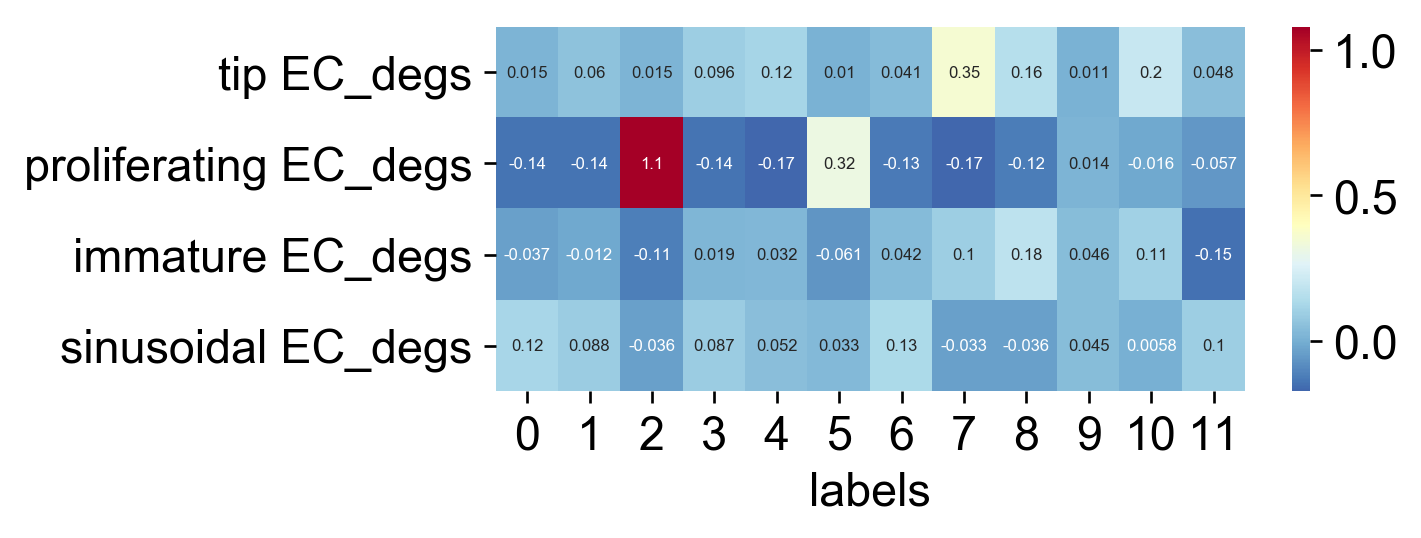

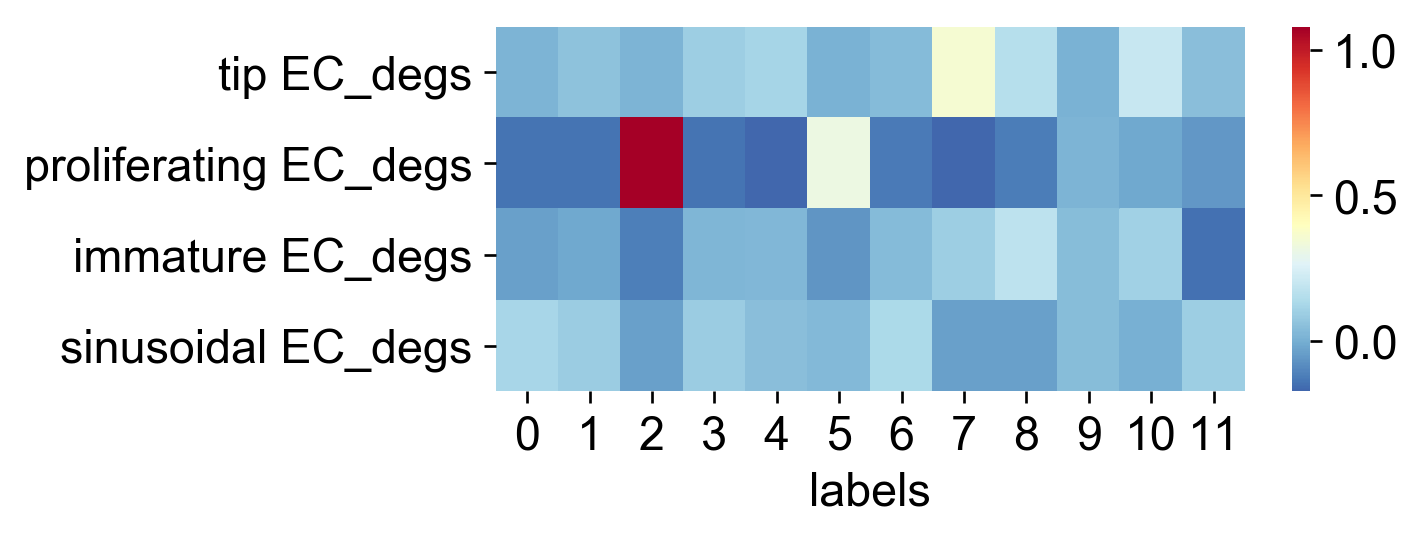

In [58]:
plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", center=0.4, annot_kws={"size": 5}, cmap="RdYlBu_r").get_figure()
fig.savefig("figures/figs4e_fl_fbm_endo_numbers_yes_20200512.pdf")
# plot gene scores as a heatmap. 
plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r›", center=0.4).get_figure() 
fig.savefig("figures/figs4e_fl_fbm_endo_numbers_no_20200512.pdf")

# Save data

In [59]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [60]:
adata.X

<3348x27080 sparse matrix of type '<class 'numpy.float32'>'
	with 8243025 stored elements in Compressed Sparse Row format>

In [61]:
adata.raw.X

<3348x27080 sparse matrix of type '<class 'numpy.float32'>'
	with 9421740 stored elements in Compressed Sparse Row format>

In [62]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs4e_fl_fbm_endo_enrichment_20200512.h5ad")